#  Quantization aware (QKeras) GraphConv Neural Network for Jet tagging using jet constituents from HLS data using CONV1D layers on fully conected graphs

## Author: Andre Sznajder

 

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'


# Load HLS4ML dataset 

## Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

## https://github.com/pierinim/tutorials/blob/master/GGI_Jan2021/Lecture1/Notebook1_ExploreDataset.ipynb

 * 'jetImage' contains the image representation of the jets (more later)

 * 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)

 * 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored

 * 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList' 'jets' is the dataset we consider for the moment

 * 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'


In [3]:
import numpy as np
import h5py
import os

# for pT, eta_rel, phi_rel
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
# for px, py, pz
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
#   myJetConstituentList = np.array(f.get("jetConstituentList"))
#
# Jet Constituents Features =  [0='j1_px', 1='j1_py', 2='j1_pz', 3='j1_e', 4='j1_erel', 5='j1_pt', 6='j1_ptrel',
#                         7='j1_eta', 8='j1_etarel', 9='j1_etarot', 10='j1_phi', 11='j1_phirel', 12='j1_phirot',
#                         13='j1_deltaR', 14='j1_costheta', 15='j1_costhetarel', 16='j1_pdgid']



#Data PATH
TRAIN_PATH = '/Users/sznajder/WorkM1/workdir/data/hls4ml_LHCjet_150p/'

# Prepare the DATA
#target = np.array([])
#jetConstituent = np.array([])
#jetImage = np.array([])

first=True
for file in os.listdir(TRAIN_PATH):
  print("Appending %s" %file)

  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
#        jetImage= data['jetImage'][:,:,:] 
        target = data['jets'][:,-6:-1]
    
        print("Keys in H5PY files = ",list( data.keys() ))
        print(" ")
        featurenames = data.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        # the b is due to the byte vs utf-8 encoding of the strings in the dataset
        # just ignore them for the moment
        print(" ")
        featurenames = data.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = data.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")

    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
         # Read (Pt,Eta,Phi)
#        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,7,10]] ] , axis=0 )
#        jetImage = np.concatenate( [ jetImage, data['jetImage']    ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )

                                    
print("Target shape =", target.shape)
print("Jet Constituents shape =", jetConstituent.shape)
#print("Jet Image shape =", jetImage.shape)


Appending jetImage_6_150p_40000_50000.h5
Keys in H5PY files =  ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
 
Jets Features =  [b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'

# The image dataset

Jets can be converted to images considering the (&eta;, &phi;) plane, centered along the axis direction and binned.
In our case, we consider a square of 1.6x1.6 in size (because the jet size is R=0.8) binned in 100x100 equal-size 'cells'


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



In [4]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# 1st dim is jet image index
# 2nd dim is image eta bin
# 3rd dim is image phi bin
njet = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat = jetConstituent.shape[2]

print('Shape of jetConstituent =',jetConstituent.shape)
print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

# Filter out constituents with Pt<2GeV
Ptmin =2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1


# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]

del constituents

# Restric the number of constituents to a maximum of NMAX
nmax = 8
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]

print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)


Shape of jetConstituent = (880000, 150, 3)
Number of jets = 880000
Number of constituents = 150
Number of features = 3
Number of jets = 880000
Number of constituents = 8
Number of features = 3


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [5]:
from sklearn.model_selection import train_test_split

X = jetConstituent
Y = target
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

del jetConstituent
del target 

#print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of Z jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))

print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of Z jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))





number of G jets for training/validation: 118789
number of Q jets for training/validation: 114175
number of W jets for training/validation: 118845
number of Z jets for training/validation: 118615
number of T jets for training/validation: 119176
number of G jets for testing: 58463
number of Q jets for testing: 56504
number of W jets for testing: 58327
number of Z jets for testing: 58337
number of T jets for testing: 58769


## Define a GraphConv NN by applaying a convolutional layer (Conv1D) over each node of a fully connected Graph. Weights of  convolutional filter ( kernel ) are shared across the nodes by using a convolution sliding window of the size of the node features vector (kernel size) and a stride equal to the kernel size. 

### OBS: this Conv1D approach is equivalent to applying a a given MLP to each node individually and then aggregating the outputs

In [83]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Flatten 
from tensorflow.keras import utils
from qkeras import *

###########################################################################
# Define GraphConv Model 

'''
# For 32 constituents
point_channels=18   
nhidden = int(nconstit*nfeat/12.)              
'''

'''
# For 16 constituents
point_channels=16                  
nhidden = int(nconstit*nfeat/3.) 
'''

#'''
# For 8 constituents ( 3 hidden layers )
nchannels = 36                 
nhidden = int(nconstit*nfeat*.63) 
#'''



# Number of target classes
ntargets = len(Y_train_val[0]) 

#############################################################################


# Quantized bits
nbits=2
integ=0

#qbits = quantized_bits(nbits,integ,alpha=1.0)
#qact = 'quantized_relu('+str(nbits)+',0)'

# Set QKeras quantizer and activation 
if nbits == 1:
    qbits = 'binary(alpha=1)'
elif nbits == 2:
    qbits = 'ternary(alpha=1)'
else:
    qbits = 'quantized_bits({},0,alpha=1)'.format(nbits)

qact = 'quantized_relu({},0)'.format(nbits)



# Print
print("Trainign with max # of contituents = ", nconstit)
print("Number of node features = ", nfeat)
print("Quantization with nbits=",nbits)
print("Quantization of integer part=",integ)


#############################################################################


# Instantiate Tensorflow input tensors in Batch mode 
inp = Input(shape=(nconstit,nfeat), name="input")   # Conv1D input format
#inp = Input(shape=(1,nconstit,nfeat), name="input")    # Conv2D input format


# Input point features BatchNormalization 
h = BatchNormalization(name='BatchNorm')(inp)

# Conv1D with kernel_size=1 and stride=1 to implement a MLP like aggregation of 
#   input point features ( pt, eta_rel, phi_rel)
h  = QConv1D(nchannels, kernel_size=1, strides=1, name='conv1D',
             kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="True" )(h)

#h  = QConv2D(nchannels, kernel_size=(1,1), strides=(1,1), name='Conv1D',
#             kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="True" )(h)


h = QActivation( activation = qact, name = 'activation_conv')(h)

# Flatten for MLP input
h=Flatten(name='Flatten')(h)

# Dense layers for classification
h = QDense(int(nhidden*0.94), name='dense1', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activation_dense1')(h)

h = QDense(nhidden, name='dense2', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activation_dense2')(h)

h = QDense(nhidden, name='dense3', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activation_dense3')(h)


out = QDense(ntargets, name='denseOut', kernel_quantizer=qbits, bias_quantizer=qbits )(h)  # (N, num_classes)
out = Activation("softmax", name="softmx")(out)

# Build the model
model = Model(inputs=inp, outputs=out)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0001,decay=1e-6)
optim = Adam(learning_rate=0.0001)
#optim = Adam(learning_rate=0.0002)
#optim = Adam()

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()



Trainign with max # of contituents =  8
Number of node features =  3
Quantization with nbits= 2
Quantization of integer part= 0
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 8, 3)]            0         
_________________________________________________________________
BatchNorm (BatchNormalizatio (None, 8, 3)              12        
_________________________________________________________________
conv1D (QConv1D)             (None, 8, 36)             144       
_________________________________________________________________
activation_conv (QActivation (None, 8, 36)             0         
_________________________________________________________________
Flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense1 (QDense)              (None, 14)                4046   

## Run training
Here, we run the training.

In [84]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import KFold

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('QGraphConv_model.h5', monitor='val_categorical_accuracy', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

#print("X_train_val before expandims=",X_train_val.shape)
#X_train_val = tf.expand_dims(X_train_val,axis=1)  # Reshape tensor for using Conv2D
#print("X_train_val after expanddims=",X_train_val.shape)

# Train classifier
history = model.fit(  X_train_val , Y_train_val, 
                    epochs=300, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls], 
                    validation_split=0.3 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 
 

# Set model and output name
arch = 'QGraphConv'
fname = arch+'_nconst_'+str(nmax)+'_nbits_'+str(nbits)
print('Saving Model : ',fname)


# Save the model
model.save('model_'+fname+'.h5')

## Save the model weights in a separate file
model.save_weights('weights_'+fname+'.h5')

Epoch 1/300
807/807 [==============================] - 2s 2ms/step - loss: 1.6776 - categorical_accuracy: 0.2057 - val_loss: 1.6357 - val_categorical_accuracy: 0.2254
Epoch 2/300
807/807 [==============================] - 2s 2ms/step - loss: 1.5946 - categorical_accuracy: 0.2527 - val_loss: 1.5857 - val_categorical_accuracy: 0.2767
Epoch 3/300
807/807 [==============================] - 2s 2ms/step - loss: 1.5687 - categorical_accuracy: 0.2653 - val_loss: 1.5471 - val_categorical_accuracy: 0.2876
Epoch 4/300
807/807 [==============================] - 2s 2ms/step - loss: 1.5477 - categorical_accuracy: 0.2702 - val_loss: 1.5462 - val_categorical_accuracy: 0.2457
Epoch 5/300
807/807 [==============================] - 2s 2ms/step - loss: 1.5127 - categorical_accuracy: 0.2611 - val_loss: 1.4874 - val_categorical_accuracy: 0.2654
Epoch 6/300
807/807 [==============================] - 2s 2ms/step - loss: 1.5004 - categorical_accuracy: 0.2829 - val_loss: 1.4896 - val_categorical_accuracy: 0.307

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))


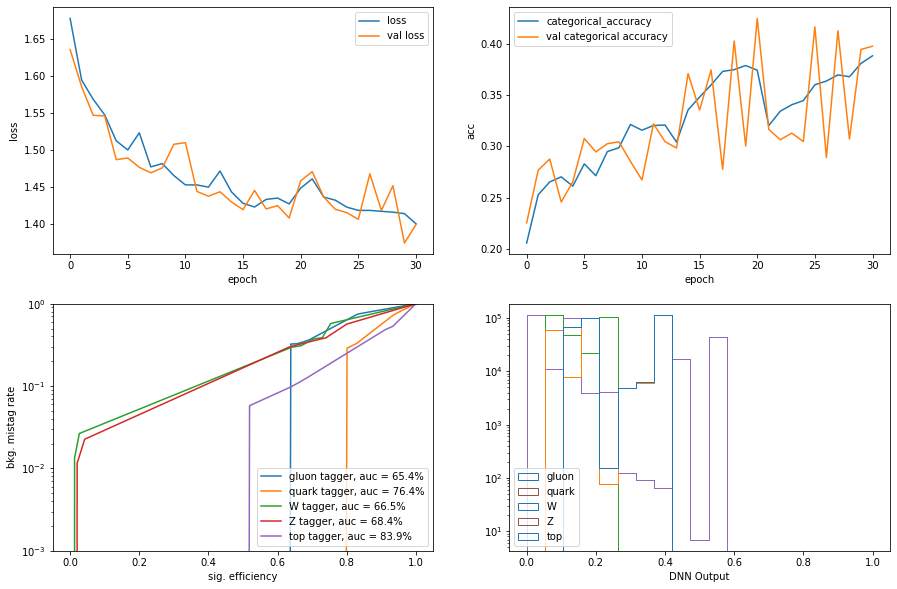

In [85]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}


ax = plt.subplot(2, 2, 3)
Y_predict = model.predict(X_test)


# Loop over classes(labels) to get metrics per class
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))


ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')

# Display plots
fig = plt.gcf()
plt.show()


In [86]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)


# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)
  
'''
# Save confusion matrix ndarrays to .npz file
with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
    vars = {}
    vars[arch]=np.array(1) # save model name
    for label in labels:
        vars['tresholds_'+label+'_'+arch] = tresholds[label]
        vars['TP_'+label+'_'+arch] = TP[label]
        vars['FP_'+label+'_'+arch] = FP[label]
        vars['TN_'+label+'_'+arch] = TN[label]
        vars['FN_'+label+'_'+arch] = FN[label]
        vars['TPR_'+arch] = tpr[label]
        vars['FPR_'+arch] = fpr[label]
        vars['NP_'+arch]= NP[label]
        vars['NN_'+arch]= NN[label]
        vars['auc_'+arch] = auc1[label] 
#        print(vars)
    np.savez(file, **vars)
'''

# Get average ( between classes ) accuracy score 
#y_keras = model.predict(X_test)
# y_hls = hls_model.predict(np.ascontiguousarray(X_test))
# accuracy_keras  = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(y_keras,axis=1)))
# accuracy_hls4ml = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(y_hls,axis=1)))






Label =  gluon  with treshold =  0.3
TPR =  0.6380958897080204
FPR =  0.3239069230006424
 
Label =  gluon  with treshold =  0.5
TPR =  0.6380958897080204
FPR =  0.3239069230006424
 
Label =  gluon  with treshold =  0.8
TPR =  0.8310213297299146
FPR =  0.7462198786739502
 
Label =  quark  with treshold =  0.3
TPR =  0.800722072773609
FPR =  0.2872515990012655
 
Label =  quark  with treshold =  0.5
TPR =  0.800722072773609
FPR =  0.2872515990012655
 
Label =  quark  with treshold =  0.8
TPR =  0.800722072773609
FPR =  0.2872515990012655
 
Label =  W  with treshold =  0.3
TPR =  0.6391208188317589
FPR =  0.2944116721893542
 
Label =  W  with treshold =  0.5
TPR =  0.6391208188317589
FPR =  0.2944116721893542
 
Label =  W  with treshold =  0.8
TPR =  1.0
FPR =  1.0
 
Label =  Z  with treshold =  0.3
TPR =  0.631983132488815
FPR =  0.2961911205146878
 
Label =  Z  with treshold =  0.5
TPR =  0.631983132488815
FPR =  0.2961911205146878
 
Label =  Z  with treshold =  0.8
TPR =  0.800006856711

"\n# Save confusion matrix ndarrays to .npz file\nwith open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:\n    vars = {}\n    vars[arch]=np.array(1) # save model name\n    for label in labels:\n        vars['tresholds_'+label+'_'+arch] = tresholds[label]\n        vars['TP_'+label+'_'+arch] = TP[label]\n        vars['FP_'+label+'_'+arch] = FP[label]\n        vars['TN_'+label+'_'+arch] = TN[label]\n        vars['FN_'+label+'_'+arch] = FN[label]\n        vars['TPR_'+arch] = tpr[label]\n        vars['FPR_'+arch] = fpr[label]\n        vars['NP_'+arch]= NP[label]\n        vars['NN_'+arch]= NN[label]\n        vars['auc_'+arch] = auc1[label] \n#        print(vars)\n    np.savez(file, **vars)\n"

In [25]:
# Save a sample of events for Thea test on HLS

print(X_test.shape)

'''
njets=3000
print(X_test.shape)
np.save('x_test_8const.npy', X_test[0:njets,:])
np.save('y_test_8const.npy', Y_test[0:njets,:])
'''
np.save('x_test_8const_full.npy', X_test)
np.save('y_test_8const_full.npy', Y_test)

(290400, 8, 3)
